In [ ]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft


client = tt.startdask(nthreads=1,n_workers = 52)

client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37419 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:38259' processes=52 threads=52, memory=416.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37419/status,
Dashboard: /proxy/37419/status,Workers: 52
Total threads: 52,Total memory: 416.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38259,Workers: 52
Dashboard: /proxy/37419/status,Total threads: 52
Started: Just now,Total memory: 416.00 GiB
Comm: tcp://127.0.0.1:35553,Total threads: 1
Dashboard: /proxy/46491/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:33231,


2025-05-09 15:08:38,792 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:39267'.
2025-05-09 15:08:38,796 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:37081'.
2025-05-09 15:08:38,800 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:40635'.
2025-05-09 15:08:38,803 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:34125'.
2025-05-09 15:08:38,805 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:32863'.
2025-05-09 15:08:38,807 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:35553'.
2025-05-09 15:08:38,809 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:45533'.
2025-05-09 15:08:38,811 - distributed.scheduler - WARNING - Received heartbeat from unregistered 

# EF reflection plan:

Still an unresolved question! Do we 
1. Use a geometric argument to filter the incoming and reflected EF?

    Pros:
     - Easy to explain and implement

    Cons:
     - A bit subjective as to area chosen
     - Likely hard to see a clean result
2. Or do a directional filter first

    Pros:
     - Easier to compare to Klymak 2016
     - Easy to interpret

    Cons:
     - FFT too close to boundary, could get edge effects
     - Have to handle / explain cross terms

## General to do:

* Choose the surface / contour integral. Either straight lines, or follow an isobath
* Write function to take surface integral for EF input


# Load in the stuff we saved earlier!


In [21]:
expt = "full-10"

data = {}
for expt in ["full-10","beamless-10","smooth-10","beamless-20","smooth-20","full-20","full-40","beamless-40","smooth-40"]:
# for expt in ["beamless-40"]:
    path = Path(f"/scratch/nm03/ab8992/april-manytimes") / expt
    bathy = xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc").sel(yb = slice(-120,120))
    times = os.listdir(path)
    data[expt] = xr.merge(
    [
        xr.open_dataset(path / times[0] / "EF_alongbeam.nc",decode_times= False).rename({"EF":"EF_alongbeam"}).mean("time").load(),
        xr.open_dataset(path / times[0] / "EF_acrossbeam.nc",decode_times= False).rename({"EF":"EF_acrossbeam"}).mean("time").load(),
        xr.open_dataset(path / times[0] / "EF_alongbeam_forward.nc",decode_times= False),
        xr.open_dataset(path / times[0] / "EF_alongbeam_backward.nc",decode_times= False),
        xr.open_dataset(path / times[0] / "EF_alongbeam_xterm.nc",decode_times= False),
        xr.open_dataset(path / times[0] / "EF_acrossbeam_forward.nc",decode_times= False),
        xr.open_dataset(path / times[0] / "EF_acrossbeam_backward.nc",decode_times= False),
        xr.open_dataset(path / times[0] / "EF_acrossbeam_xterm.nc",decode_times= False),
        xr.open_dataset(path / times[0] / "filtered_dissipation.nc",decode_times= False),
        bathy.rename({"depth":"bathy"}) * -1
     ]
).sel(xb = slice(0,1200)).expand_dims({"time":[times[0].split("t0-")[1]]})
    for i in range(1,len(times)):

        try:
            data[expt] = xr.concat(
            [
                data[expt],
                xr.merge(
                    [
                        xr.open_dataset(path / times[i] / "EF_alongbeam.nc",decode_times= False).rename({"EF":"EF_alongbeam"}).mean("time").load(),
                        xr.open_dataset(path / times[i] / "EF_acrossbeam.nc",decode_times= False).rename({"EF":"EF_acrossbeam"}).mean("time").load(),
                        xr.open_dataset(path / times[i] / "EF_alongbeam_forward.nc",decode_times= False),
                        xr.open_dataset(path / times[i] / "EF_alongbeam_backward.nc",decode_times= False),
                        xr.open_dataset(path / times[i] / "EF_alongbeam_xterm.nc",decode_times= False),
                        xr.open_dataset(path / times[i] / "EF_acrossbeam_forward.nc",decode_times= False),
                        xr.open_dataset(path / times[i] / "EF_acrossbeam_backward.nc",decode_times= False),
                        xr.open_dataset(path / times[i] / "EF_acrossbeam_xterm.nc",decode_times= False),
                        xr.open_dataset(path / times[i] / "filtered_dissipation.nc",decode_times= False),
                        bathy.rename({"depth":"bathy"}) * -1
                    ]
                ).sel(xb = slice(0,1200)).expand_dims({"time":[times[i].split("t0-")[1]]}),
            ],
            dim = "time"
            )
        except Exception as e:
            print(f"Error processing time {times[i]} for experiment {expt}: {e}")

    # data[expt] = data[expt].mean("time")


FileNotFoundError: [Errno 2] No such file or directory: '/scratch/nm03/ab8992/april-manytimes/smooth-40/t0-5040/EF_alongbeam_forward.nc'

In [12]:
data["full-40"].time

<xarray.DataArray 'time' (time: 13)> Size: 104B
array(['5040', '7920', '6480', '22200', '4320', '9360', '10800', '8640',
       '4216', '4416', '7200', '10080', '5760'], dtype=object)
Coordinates:
  * time     (time) object 104B '5040' '7920' '6480' ... '7200' '10080' '5760'
    zi       float64 8B 10.79

## Test out a basic straight line segment contour plot

Incoming: -26.7 -5.5 kW/m
Outgoing: 21.5 2.7 kW/m
Xterm: -13.5 -0.5 kW/m


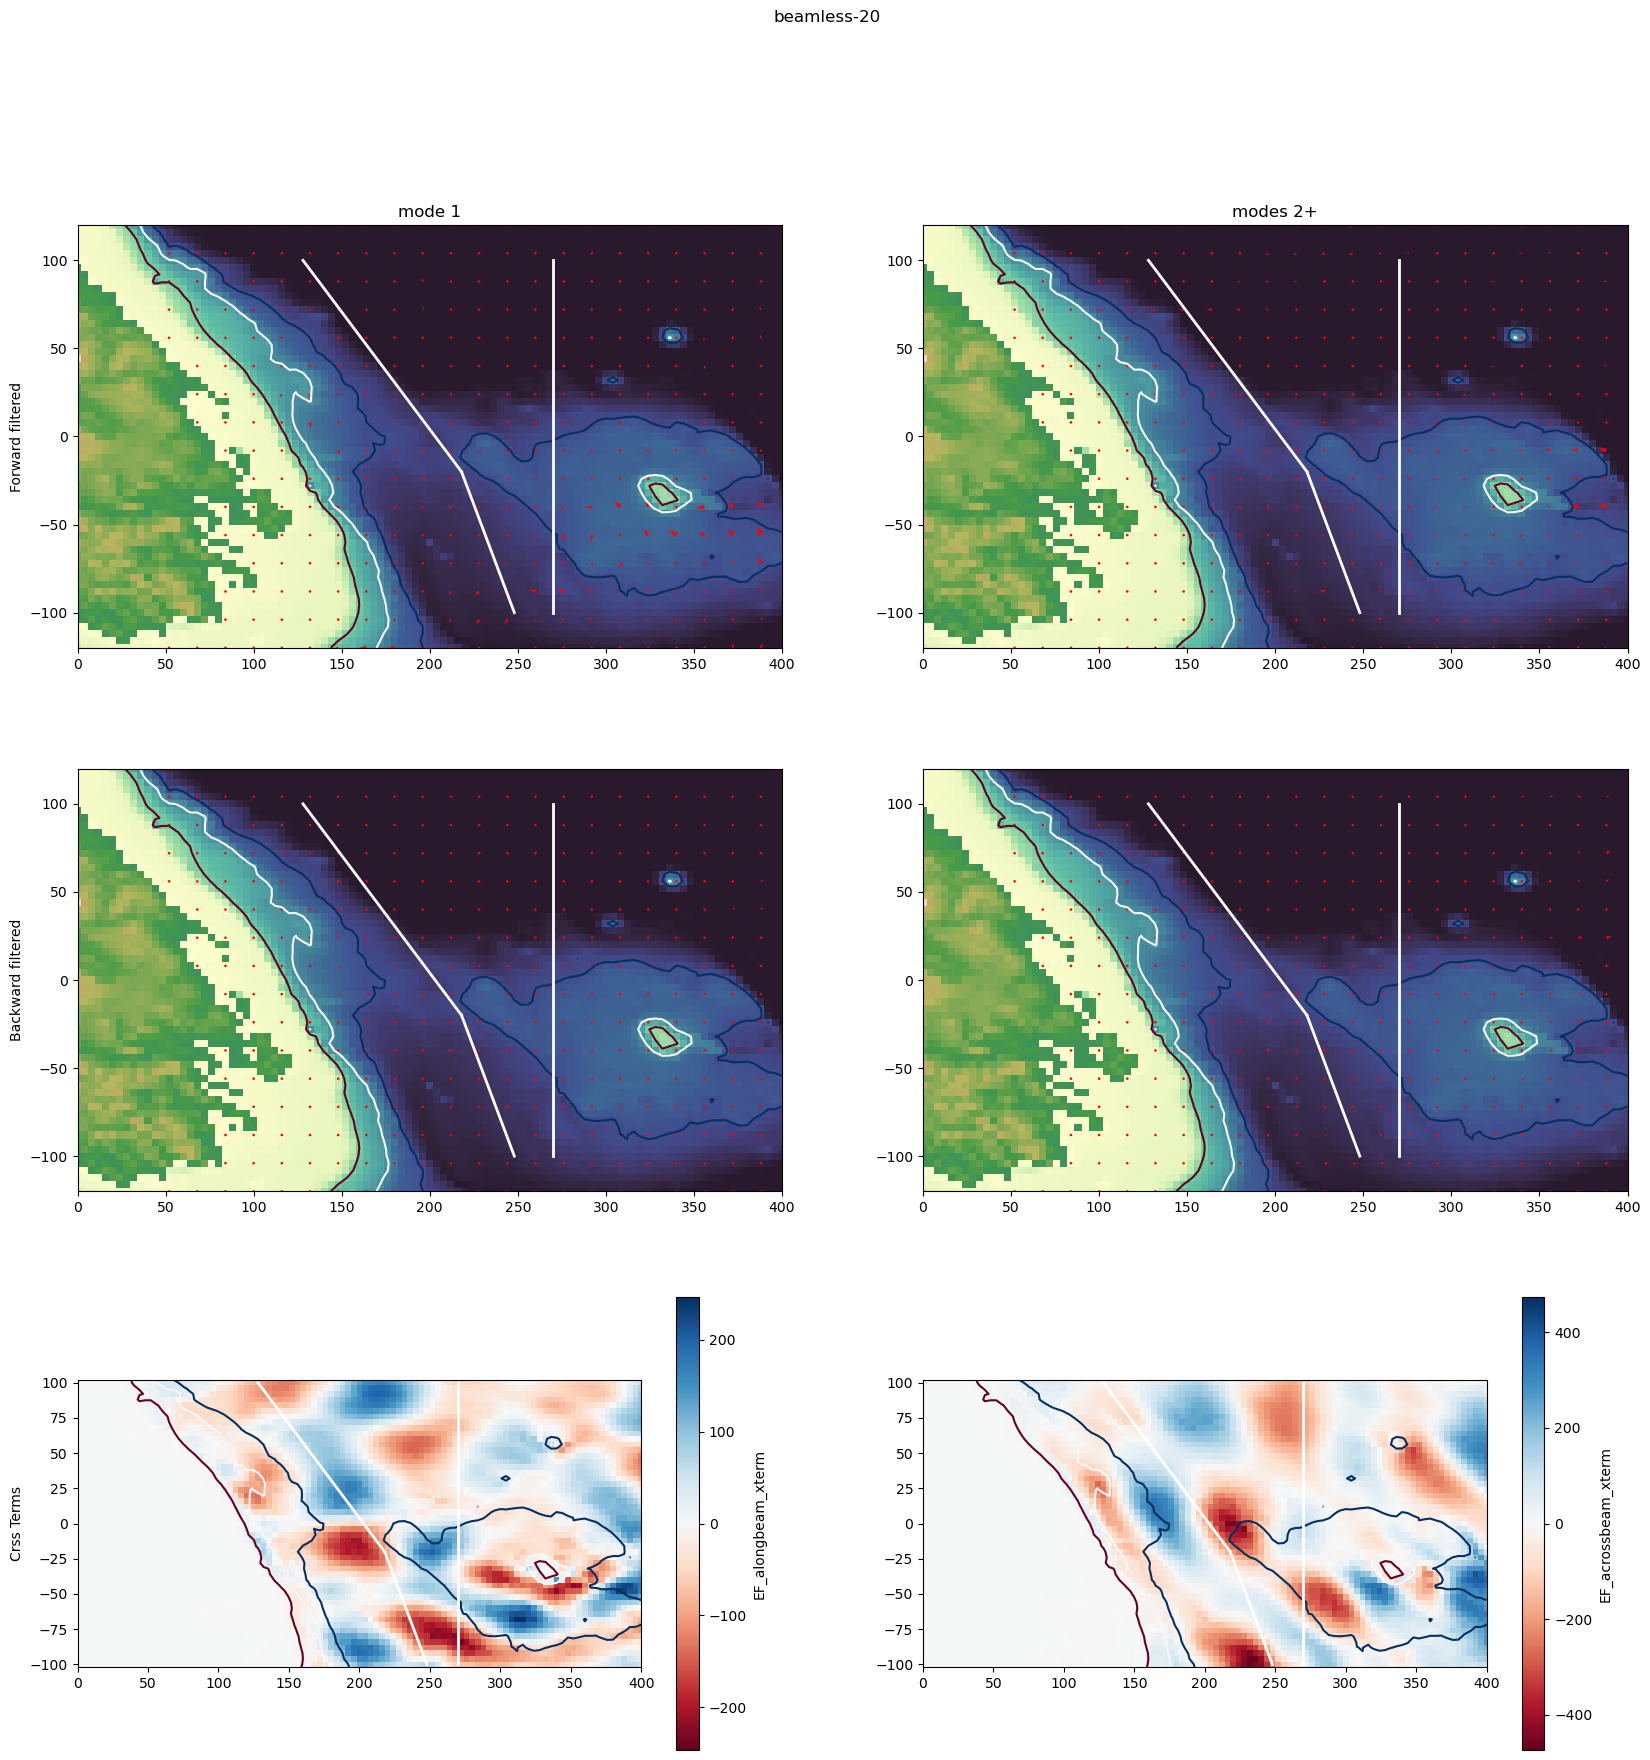

In [8]:
## Define EF integrating, masking and plotting functions
def plot_KE_quiver(alongbeam,acrossbeam,ax,mode = 0,xlim = slice(50,250),ylim = slice(-80,80),scale = 3000):
    # expt = "full-20"
    alongbeam = alongbeam.sel(xb = xlim,yb = ylim).isel(mode = mode)
    acrossbeam = acrossbeam.sel(xb = xlim,yb = ylim).isel(mode = mode)

    if "mode" in alongbeam.dims:
        alongbeam = alongbeam.sum("mode")
        acrossbeam = acrossbeam.sum("mode")

    # np.sqrt(acrossbeam**2 + alongbeam**2).sum("mode").plot(ax = ax)
    yspacing = 2
    xspacing = 2
    if "20" in expt:
        yspacing,xspacing = yspacing * 2, xspacing * 2
    elif "40" in expt:
        yspacing,xspacing = yspacing * 4, xspacing * 4
    _yb = acrossbeam.yb[::yspacing]
    _xb = acrossbeam.xb[::xspacing]
    _along = (alongbeam )[::yspacing,::xspacing]
    _across = (acrossbeam)[::yspacing,::xspacing]

    # print(magnitude)
    ax.quiver(_xb, _yb, _along, _across, color="red", scale=scale,scale_units = "width",width = 0.004)
    tt.plot_topo(ax,xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc").depth * -1)

    ax.set_ylim(-120,120)
    ax.set_xlim(0,1200)
    ax.set_xlabel("")
    ax.set_ylabel("")


def contour_mask_singleline(xs,ys,data):
    """
    Returns umask,vmask
    """
    dx = (data.yb[1] - data.yb[0]).values
    if xs[0] == xs[1]: # HANDLE VERTICAL LINE
        return xr.where(
            (np.abs(data.xb - xs[0]) < dx) *
            (data.yb > ys[0]) * 
            (data.yb < ys[1])            
            ,1,0
        ).fillna(0), data * 0
    if ys[0] == ys[1]: # HANDLE HORIZONTAL LINE
        return data * 0,xr.where(
            (np.abs(data.yb - ys[0]) < dx) *
            (data.xb > xs[0]) * 
            (data.xb < xs[1])
            ,1,0
        ).fillna(0)
    
    ## Deal with an angled line
    m = (ys[1] - ys[0]) / (xs[1] - xs[0])
    c = ys[0] - m * xs[0]

    ## V mask first. So, we need unique points in x
    x_points = np.arange(xs[0],xs[1],dx)
    y_points = m * x_points + c
    # y_points = np.round(y_points,1)
    x_points = np.round(x_points,0)
    vmask = xr.where(
        (np.abs(data.xb - x_points[0]- 1e-5)  <= dx/2) *
        (np.abs(data.yb - y_points[0]- 1e-5)  <= dx/2)
        ,1,0
        )
    for i in range(1,len(x_points)):
        vmask += xr.where(
            (np.abs(data.xb - x_points[i] - 1e-5)  <= dx/2) *
            (np.abs(data.yb - y_points[i] - 1e-5)  <= dx/2)
            ,1,0
            )
    ## U mask second. So, we need unique points in y
    y_points = np.arange(np.min(ys),np.max(ys),dx)
    x_points = (y_points - c) / m
    umask = xr.where(
        (np.abs(data.xb - x_points[0]- 1e-5)  <= dx/2) *
        (np.abs(data.yb - y_points[0]- 1e-5)  <= dx/2)
        ,1,0
        )
    for i in range(1,len(x_points)):
        umask += xr.where(
            (np.abs(data.xb - x_points[i] - 1e-5)  <= dx/2) *
            (np.abs(data.yb - y_points[i] - 1e-5)  <= dx/2)
            ,1,0
            )

    return umask,vmask

def contour_mask_compound(xs,ys,data):
    umask,vmask = contour_mask_singleline(xs[0],ys[0],data)
    length = 0
    for i in range(1,len(xs)):
        u,v = contour_mask_singleline(xs[i],ys[i],data)
        umask += u
        vmask += v
        length += np.sqrt((xs[i][1] - xs[i][0])**2 + (ys[i][1] - ys[i][0])**2) * 1000

    return xr.merge(
        [xr.where(umask == 0,0,1).rename("umask") , xr.where(vmask == 0,0,1).rename("vmask"),xr.DataArray(length).rename("length")])

def contour_integral(xs,ys,alongbeam,acrossbeam):
    """
    Pass x and y coords of straight line. Need to pre-multiply data to get orientation to line 
    correct as function just integrates along the line. If line is parallel to an axis, just 
    pre multiply alongbeam or acrossbeam by 0 to ensure that we don't integrate over empty dimension.
    """
    if type(xs[0]) == list:
        mask = contour_mask_compound(xs,ys,alongbeam)
        umask = mask["umask"]
        vmask = mask["umask"]
        length = mask["length"]

    else:
        umask,vmask = contour_mask_singleline(xs,ys,alongbeam)
        length = np.sqrt((xs[1] - xs[0])**2 + (ys[1] - ys[0])**2) * 1000

    out = (umask * alongbeam).sum("xb").integrate("yb")
    out += (vmask * acrossbeam).sum("yb").integrate("xb")
    out = xr.Dataset({"energy":out / 1000,"length":length})
    out["energy"].attrs["Units"] = "KW/m"
    out["energy"].attrs["length"] = "m"
    return out # Convert km -> m

offset = 28
# offset = 0
xs_incoming, ys_incoming = [[270, 270]], [[-100, 100]]
xs_reflect, ys_reflect = [[100 + offset, 190 + offset],[190 + offset, 220 + offset]], [[100, -20],[-20, -100]]
ymax = 100
expt = "beamless-20"



## Plot an example domain to show area

xmax = 400
fig,ax = plt.subplots(3,2,figsize=(20,20))
toplot = data[expt].mean("time")

for a in ax.flatten():
    toplot.sel(xb = slice(0,xmax)).bathy.plot(vmax = 0, vmin = -4000, cmap = cmocean.cm.deep_r,ax = a,add_colorbar = False)
    toplot.sel(xb=slice(0, xmax)).bathy.plot.contour(levels=[-1000,-2000,-3000],ax = a)

scale = 50000


plot_KE_quiver(toplot.EF_alongbeam,toplot.EF_acrossbeam,ax[0,0],mode = 0,xlim = slice(50,xmax),ylim = slice(None,None),scale = scale)
plot_KE_quiver(toplot.EF_alongbeam_forward,toplot.EF_acrossbeam_forward,ax[0,1],mode = slice(1,None),xlim = slice(50,xmax),ylim = slice(None,None),scale = scale / 5)
plot_KE_quiver(toplot.EF_alongbeam_backward,toplot.EF_acrossbeam_backward,ax[1,0],mode = 0,xlim = slice(50,xmax),ylim = slice(None,None),scale = scale)
plot_KE_quiver(toplot.EF_alongbeam_backward,toplot.EF_acrossbeam_backward,ax[1,1],mode = slice(1,None),xlim = slice(50,xmax),ylim = slice(None,None),scale = scale / 5)

toplot.EF_alongbeam_xterm.sum("mode").sel(xb = slice(0,xmax),yb = slice(-ymax,ymax)).plot(ax = ax[2,0],cmap = "RdBu")
toplot.EF_acrossbeam_xterm.sum("mode").sel(xb = slice(0,xmax),yb = slice(-ymax,ymax)).plot(ax = ax[2,1],cmap = "RdBu")


for a in ax.flatten():
    for x,y in zip(xs_incoming,ys_incoming):
        a.plot([x[0],x[1]],[y[0],y[1]],color = "white",linewidth = 2)
    for x,y in zip(xs_reflect,ys_reflect):
        a.plot([x[0],x[1]],[y[0],y[1]],color = "white",linewidth = 2)
    a.set_aspect('equal')
    a.set_xlabel("")
    a.set_ylabel("")
    a.set_title("")
    a.set_xlim(0,xmax)

# Incoming: -183.1 -13.8 kW/m
# Outgoing: 72.1 8.0 kW/m
# Xterm: 21.5 -0.3 kW/m

ax[0,0].set_title("mode 1")
ax[0,1].set_title("modes 2+")
ax[0,0].set_ylabel("Forward filtered")
ax[1,0].set_ylabel("Backward filtered")
ax[2,0].set_ylabel("Crss Terms")
fig.suptitle(expt)

EF_in = contour_integral(xs_reflect,ys_reflect,toplot.EF_alongbeam_forward,toplot.EF_acrossbeam_forward)
EF_out = contour_integral(xs_reflect,ys_reflect,toplot.EF_alongbeam_backward,toplot.EF_acrossbeam_backward)
EF_xterm = contour_integral(xs_reflect,ys_reflect,toplot.EF_alongbeam_xterm,toplot.EF_acrossbeam_xterm)

print(f"Incoming: {EF_in.isel(mode = 0).energy.values:.1f} {EF_in.isel(mode = slice(1,None)).sum('mode').energy.values:.1f} kW/m")
print(f"Outgoing: {EF_out.isel(mode = 0).energy.values:.1f} {EF_out.isel(mode = slice(1,None)).sum('mode').energy.values:.1f} kW/m")
print(f"Xterm: {EF_xterm.isel(mode = 0).energy.values:.1f} {EF_xterm.isel(mode = slice(1,None)).sum('mode').energy.values:.1f} kW/m")


In [19]:
data[expt].isel(time = 11).time

<xarray.DataArray 'time' ()> Size: 20B
array('10000', dtype='<U5')
Coordinates:
    time     <U5 20B '10000'
    zi       float64 8B 10.79

In [18]:

print("===  Wave energy flux onto shelf (kW/m)  ===", end="\n\n")

print(f"{'Experiment':<12}{'1 in':>12}{'1 out':>12}{'2+ in':>12}{'2+ out':>12}{'Xterm':>12}{'Total':>12}")
expts = ["beamless-10","full-10","smooth-10","beamless-20","full-20","smooth-20","beamless-40","full-40","smooth-40"]
for expt in expts:
    EF_in = contour_integral(xs_reflect,ys_reflect,data[expt].EF_alongbeam_forward,data[expt].EF_acrossbeam_forward)
    EF_out = contour_integral(xs_reflect,ys_reflect,data[expt].EF_alongbeam_backward,data[expt].EF_acrossbeam_backward)
    EF_xterm = contour_integral(xs_reflect,ys_reflect,data[expt].EF_alongbeam_xterm,data[expt].EF_acrossbeam_xterm)
    total = contour_integral(xs_reflect,ys_reflect,data[expt].EF_alongbeam,data[expt].EF_acrossbeam)
    # print(f"Incoming: {EF_in.isel(mode = 0).energy.values:.1f} {EF_in.isel(mode = slice(1,None)).sum('mode').energy.values:.1f} kW/m")
    # print(f"Outgoing: {EF_out.isel(mode = 0).energy.values:.1f} {EF_out.isel(mode = slice(1,None)).sum('mode').energy.values:.1f} kW/m")
    # print(f"Xterm: {EF_xterm.isel(mode = 0).energy.values:.1f} {EF_xterm.isel(mode = slice(1,None)).sum('mode').energy.values:.1f} kW/m")
    outstr = f"{expt:<12}{EF_in.isel(mode=0).energy.values:>12.1f}{EF_out.isel(mode=0).energy.values:>12.1f}{EF_in.isel(mode=slice(1, None)).sum('mode').energy.values:>12.1f}{EF_out.isel(mode=slice(1, None)).sum('mode').energy.values:>12.1f}{EF_xterm.sum('mode').energy.values:>12.1f}{total.sum('mode').energy.values:>12.1f}"
    print(outstr)
    if "smooth" in expt:
        print("")


===  Wave energy flux onto shelf (kW/m)  ===

Experiment          1 in       1 out       2+ in      2+ out       Xterm       Total


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [20]:
xs_reflect,ys_reflect = [150,150],[-100,100]


print("===  Wave energy flux onto shelf (kW/m)  ===", end="\n\n")

print(f"{'Experiment':<12}{'1 in':>12}{'1 out':>12}{'2+ in':>12}{'2+ out':>12}{'Xterm':>12}{'Total':>12}")
expts = ["beamless-10","full-10","smooth-10","beamless-20","full-20","smooth-20","beamless-40","full-40","smooth-40"]
for expt in expts:
    EF_in = contour_integral(xs_reflect,ys_reflect,data[expt].mean("time").EF_alongbeam_forward,data[expt].mean("time").EF_acrossbeam_forward)
    EF_out = contour_integral(xs_reflect,ys_reflect,data[expt].mean("time").EF_alongbeam_backward,data[expt].mean("time").EF_acrossbeam_backward)
    EF_xterm = contour_integral(xs_reflect,ys_reflect,data[expt].mean("time").EF_alongbeam_xterm,data[expt].mean("time").EF_acrossbeam_xterm)
    total = contour_integral(xs_reflect,ys_reflect,data[expt].mean("time").EF_alongbeam,data[expt].mean("time").EF_acrossbeam)
    # print(f"Incoming: {EF_in.isel(mode = 0).energy.values:.1f} {EF_in.isel(mode = slice(1,None)).sum('mode').energy.values:.1f} kW/m")
    # print(f"Outgoing: {EF_out.isel(mode = 0).energy.values:.1f} {EF_out.isel(mode = slice(1,None)).sum('mode').energy.values:.1f} kW/m")
    # print(f"Xterm: {EF_xterm.isel(mode = 0).energy.values:.1f} {EF_xterm.isel(mode = slice(1,None)).sum('mode').energy.values:.1f} kW/m")
    outstr = f"{expt:<12}{EF_in.isel(mode=0).energy.values:>12.1f}{EF_out.isel(mode=0).energy.values:>12.1f}{EF_in.isel(mode=slice(1, None)).sum('mode').energy.values:>12.1f}{EF_out.isel(mode=slice(1, None)).sum('mode').energy.values:>12.1f}{EF_xterm.sum('mode').energy.values:>12.1f}{total.sum('mode').energy.values:>12.1f}"
    print(outstr)
    if "smooth" in expt:
        print("")

===  Wave energy flux onto shelf (kW/m)  ===

Experiment          1 in       1 out       2+ in      2+ out       Xterm       Total
beamless-10         -9.6        12.7        -2.3         2.0        -6.7        -6.0
full-10            -33.5        13.8        -3.4         2.4       -23.0       -46.5
smooth-10         -200.0        59.8        -2.0         5.2        48.0      -100.8

beamless-20        -16.8        30.4        -6.7         4.0        -5.5        -2.1
full-20           -149.0        81.2       -18.1        10.5       -37.2      -132.9
smooth-20         -818.8       294.9       -63.8        52.5       121.5      -424.5

beamless-40        -20.0        24.4        -9.7         5.8        -8.7       -12.5
full-40           -136.4        81.5       -15.1        12.9        -7.7       -85.0


KeyError: 'smooth-40'

## Look at remote EF in time average

In [ ]:
res = 20
for res in [10,20,40]:
    print(res)
    EF_in = contour_integral(xs_reflect,ys_reflect,data[f"full-{res}"].mean("time").EF_alongbeam_forward,data[f"full-{res}"].mean("time").EF_acrossbeam_forward)
    EF_in -= contour_integral(xs_reflect,ys_reflect,data[f"beamless-{res}"].mean("time").EF_alongbeam_forward,data[f"beamless-{res}"].mean("time").EF_acrossbeam_forward)
    EF_out = contour_integral(xs_reflect,ys_reflect,data[f"full-{res}"].mean("time").EF_alongbeam_backward,data[f"full-{res}"].mean("time").EF_acrossbeam_backward)
    EF_out -= contour_integral(xs_reflect,ys_reflect,data[f"beamless-{res}"].mean("time").EF_alongbeam_backward,data[f"beamless-{res}"].mean("time").EF_acrossbeam_backward)
    EF_xterm = contour_integral(xs_reflect,ys_reflect,data[f"full-{res}"].mean("time").EF_alongbeam_xterm,data[f"full-{res}"].mean("time").EF_acrossbeam_xterm)

    in_tot = EF_in.sum("mode").energy.values
    out_tot = EF_out.sum("mode").energy.values

    print(f"Incoming: {EF_in.isel(mode = 0).energy.values:>12.2f} {EF_in.isel(mode = 1).energy.values:>12.2f} {EF_in.isel(mode = slice(2,None)).sum('mode').energy.values:>12.2f} kW/m", end = " ")
    print(f"{100 * EF_in.isel(mode = 0).energy.values/in_tot:>12.2f} {100 * EF_in.isel(mode = 1).energy.values/in_tot:>12.2f} {100 * EF_in.isel(mode = slice(2,None)).sum('mode').energy.values/in_tot:>12.2f} %")

    print(f"Outgoing: {EF_out.isel(mode = 0).energy.values:>12.2f} {EF_out.isel(mode = 1).energy.values:>12.2f} {EF_out.isel(mode = slice(2,None)).sum('mode').energy.values:>12.2f} kW/m",end = "")
    print(f"{100 * EF_out.isel(mode = 0).energy.values/out_tot:>12.2f} {100 * EF_out.isel(mode = 1).energy.values/out_tot:>12.2f} {100 * EF_out.isel(mode = slice(2,None)).sum('mode').energy.values/out_tot:>12.2f} %")

    print(f"Xterm   : {EF_xterm.isel(mode = 0).energy.values:>12.2f} {EF_xterm.isel(mode = 1).energy.values:>12.2f} {EF_xterm.isel(mode = slice(2,None)).sum('mode').energy.values:>12.2f} kW/m")

    print("")

10
Incoming:       -23.97        -1.00        -0.04 kW/m        95.81         4.02         0.18 %
Outgoing:         1.11         0.23         0.11 kW/m       76.59        15.77         7.64 %
Xterm   :       -23.54         0.43         0.16 kW/m

20
Incoming:      -132.23        -8.92        -2.45 kW/m        92.08         6.21         1.71 %
Outgoing:        50.78         4.11         2.38 kW/m       88.66         7.17         4.16 %
Xterm   :       -37.97         0.90        -0.10 kW/m

40
Incoming:      -116.44        -4.10        -1.33 kW/m        95.55         3.36         1.09 %
Outgoing:        57.14         4.11         3.02 kW/m       88.90         6.40         4.70 %
Xterm   :        -8.21         0.53        -0.05 kW/m



2025-05-09 15:08:38,773 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/worker.py", line 1250, in heartbeat
    response = await retry_operation(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/utils_comm.py", line 459, in retry_operation
    return await retry(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/utils_comm.py", line 438, in retry


/jobfs/140678416.gadi-pbs/ipykernel_93318/2733692603.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  plt.plot(-1 * EF_in_full.sum("mode").drop("zi").energy.values)
/jobfs/140678416.gadi-pbs/ipykernel_93318/2733692603.py:9: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  plt.plot(-1 * EF_in_beamless.sum("mode").drop("zi").energy.values)
/jobfs/140678416.gadi-pbs/ipykernel_93318/2733692603.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  plt.plot(EF_out_full.sum("mode").drop("zi").energy.values)
/jobfs/140678416.gadi-pbs/ipykernel_93318/2733692603.py:11: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  plt.plot(EF_out_beamless.sum("mode").drop("zi").energy.values)


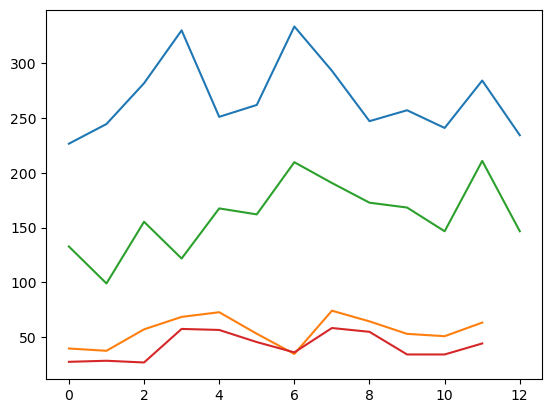

In [17]:
res = 40

EF_in_full = contour_integral(xs_reflect,ys_reflect,data[f"full-{res}"].EF_alongbeam_forward,data[f"full-{res}"].EF_acrossbeam_forward)
EF_in_beamless = contour_integral(xs_reflect,ys_reflect,data[f"beamless-{res}"].EF_alongbeam_forward,data[f"beamless-{res}"].EF_acrossbeam_forward)
EF_out_full = contour_integral(xs_reflect,ys_reflect,data[f"full-{res}"].EF_alongbeam_backward,data[f"full-{res}"].EF_acrossbeam_backward)
EF_out_beamless = contour_integral(xs_reflect,ys_reflect,data[f"beamless-{res}"].EF_alongbeam_backward,data[f"beamless-{res}"].EF_acrossbeam_backward)

plt.plot(-1 * EF_in_full.sum("mode").drop("zi").energy.values)
plt.plot(-1 * EF_in_beamless.sum("mode").drop("zi").energy.values)
plt.plot(EF_out_full.sum("mode").drop("zi").energy.values)
plt.plot(EF_out_beamless.sum("mode").drop("zi").energy.values)

/jobfs/140678416.gadi-pbs/ipykernel_84503/2589124153.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  plt.plot(-1 * EF_in_full.sum("mode").drop("zi").energy.values)
/jobfs/140678416.gadi-pbs/ipykernel_84503/2589124153.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  plt.plot(-1 * EF_in_beamless.sum("mode").drop("zi").energy.values)
/jobfs/140678416.gadi-pbs/ipykernel_84503/2589124153.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  plt.plot(EF_out_full.sum("mode").drop("zi").energy.values)
/jobfs/140678416.gadi-pbs/ipykernel_84503/2589124153.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  plt.plot(EF_out_beamless.sum("mode").drop("zi").energy.values)


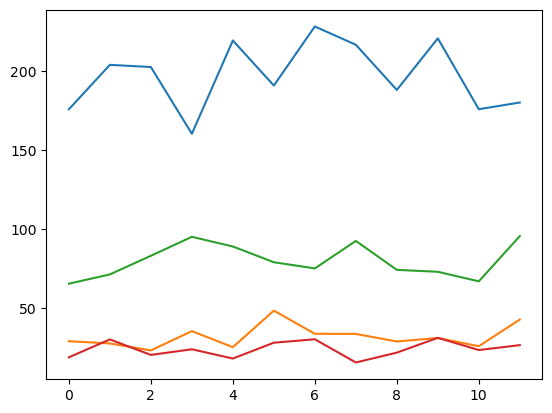